In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
import astropy.units as u

from lsst.rsp import get_tap_service, retrieve_query

service = get_tap_service("ssotap")

In [2]:
results = service.search("SELECT column_name, datatype, description, unit from TAP_SCHEMA.columns "
                         "WHERE table_name = 'dp03_catalogs.MPCORB'")
results.to_table().to_pandas()

,column_name,datatype,description,unit
0,arc,float,"MPCORB: Arc (days), for single-opposition objects",days
1,arcEnd,char,MPCORB: Year of last observation (for multi-op...,
2,arcStart,char,MPCORB: Year of first observation (for multi-o...,
3,computer,char,MPCORB: Computer name,
4,e,double,MPCORB: Orbital eccentricity,
5,epoch,double,"MPCORB: Epoch (in MJD, .0 TT)",MJD
6,flags,int,MPCORB: 4-hexdigit flags. See https://minorpla...,
7,fullDesignation,char,MPCORB: Readable designation,
8,incl,double,"MPCORB: Inclination to the ecliptic, J2000.0 (...",degrees
9,lastIncludedObservation,float,MPCORB: Date of last observation included in o...,MJD


In [3]:
# Omega = Longitude of the ascending node = "node" (deg)
# omega = Argument of periapsis, in this case, perihelion = "peri" (deg)

# Following query can take up a few minutes

In [3]:
df_mpcorb = service.search("SELECT ssObjectId,e,incl,mpcH,q,node,peri FROM dp03_catalogs.MPCORB").to_table() #.to_pandas()


In [4]:
print (type(df_mpcorb))

<class 'astropy.table.table.Table'>


In [5]:
print (len(df_mpcorb))

14600302


In [6]:
q = df_mpcorb['q']
e = df_mpcorb['e']
a = q/(1.0-e)
df_mpcorb['a'] = a

In [7]:
mask_tnos = (a > 30) & (q > 20)
tnos = df_mpcorb[mask_tnos]

In [8]:
print (len(tnos))
print (type(tnos))

58916
<class 'astropy.table.table.Table'>


In [9]:
q_tnos = tnos['q']
e_tnos = tnos['e']
a_tnos = q_tnos/(1.-e_tnos)
i_tnos = tnos['incl']*180/np.pi
H_tnos = tnos['mpcH']

In [10]:
# Estimate a SS body's diameter (very roughly!) in km from its solar system absolute magnitude, H, and albedo, a:
def estDiamFromHandAlbedo(H, a=0.15):
    estDiam = np.power(10., 3.1236 - 0.5*np.log10(a) - 0.2*H)
    return estDiam

(0.0, 500.0)

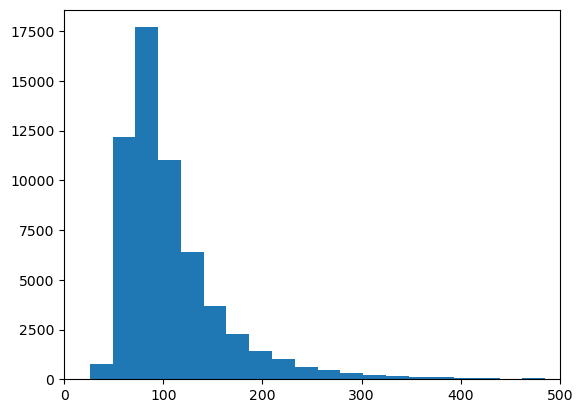

In [11]:
sizes_tnos = estDiamFromHandAlbedo(H_tnos)

n_bins = 100
fig, axs = plt.subplots(1, 1)
axs.hist(sizes_tnos, bins=n_bins)
plt.xlim([0, 500])

#### Let's define some loose cuts to clasify the TNOs in dynamical classes (scattering, detached, classical, extreme). More robust dynamical classification can be found in Bernardinelli+2020(?) using orbital fits 

In [12]:
mask_classical = (a_tnos > 40) & (a_tnos < 47) & (e_tnos < 0.24)
#mask_classical = (e_tnos < 0.24)
mask_detached = (a_tnos > 47 ) & (e_tnos > 0.24) & (q_tnos > 38)
mask_scattering = ~mask_classical & (q_tnos < 38)
mask_extreme = (a_tnos > 150) & (q_tnos > 30)

In [13]:
len(tnos)

58916

In [14]:
classes = np.repeat('Other', len(tnos))

In [15]:
len(classes)

58916

In [16]:
classes[mask_classical] = 'Classical'
classes[mask_detached] = 'Detached'
classes[mask_scattering] = 'Scattering'
classes[mask_extreme] = 'Extreme'

In [17]:
# Add the extra column to the TNO table
tnos['class'] = classes

In [18]:
len(classes[mask_classical]) + len(classes[mask_detached]) + len(classes[mask_scattering]) + len(classes[mask_extreme])

53882

In [19]:
len(tnos['class'])

58916

In [20]:
class_strings = np.unique(tnos['class'])
print(class_strings)

class
-----
Class
Detac
Extre
Other
Scatt


In [21]:
tnos['class']

Scatt
Scatt
Scatt
Detac
Scatt
Scatt
Scatt
Scatt
Scatt
Detac
Other


In [23]:
colors = ['xkcd:lighter purple', 'xkcd:light orange', 'xkcd:neon pink', 'black', 'xkcd:cerulean blue']
class_to_color = {}
for i, c in enumerate(class_strings):
    class_to_color[c] = colors[i]

In [144]:
class_to_color


{'Class': 'xkcd:lighter purple',
 'Detac': 'xkcd:light orange',
 'Extre': 'xkcd:neon pink',
 'Other': 'black',
 'Scatt': 'xkcd:cerulean blue'}

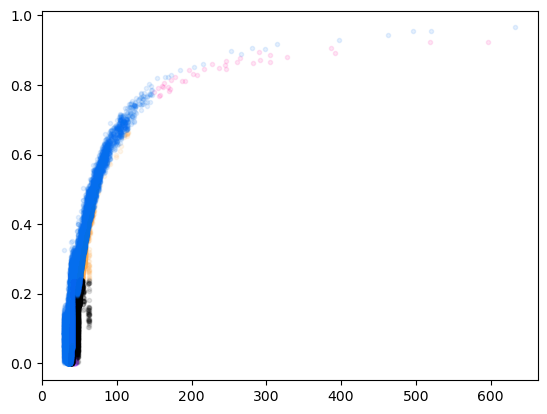

In [145]:
fig = plt.figure()
for tno_class in class_to_color:
    temp = tnos[tnos['class'] == tno_class]
    plt.plot(temp['q']/(1.-temp['e']), temp['e'], '.', alpha=0.1, color=class_to_color[tno_class])
    #plt.xlim([20, 500])

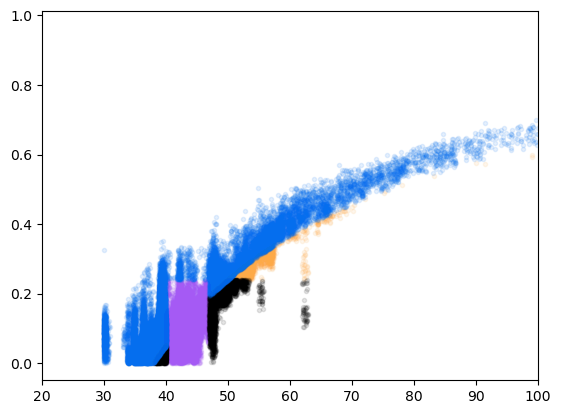

In [146]:
fig = plt.figure()
for tno_class in class_to_color:
    temp = tnos[tnos['class'] == tno_class]
    plt.plot(temp['q']/(1.-temp['e']), temp['e'], '.', alpha=0.1, color=class_to_color[tno_class])
    plt.xlim([20, 100])

In [53]:
# Gradient code copied from https://stackoverflow.com/questions/29321835/is-it-possible-to-get-color-gradients-under-curve-in-matplotlib
import matplotlib.colors as mcolors
from matplotlib.patches import Polygon


def gradient_fill(x, y, alpha=1, fill_color=None, ax=None, **kwargs):
    """
    Plot a line with a linear alpha gradient filled beneath it.

    Parameters
    ----------
    x, y : array-like
        The data values of the line.
    fill_color : a matplotlib color specifier (string, tuple) or None
        The color for the fill. If None, the color of the line will be used.
    ax : a matplotlib Axes instance
        The axes to plot on. If None, the current pyplot axes will be used.
    Additional arguments are passed on to matplotlib's ``plot`` function.

    Returns
    -------
    line : a Line2D instance
        The line plotted.
    im : an AxesImage instance
        The transparent gradient clipped to just the area beneath the curve.
    """
    if ax is None:
        ax = pl.gca()

    line, = ax.plot(x, y, alpha=0, **kwargs)
    if fill_color is None:
        fill_color = line.get_color()

    zorder = line.get_zorder()
    #alpha = line.get_alpha()
    #alpha = 1.0 if alpha is None else alpha

    z = np.empty((100, 1, 4), dtype=float)
    rgb = mcolors.colorConverter.to_rgb(fill_color)
    z[:,:,:3] = rgb
    z[:,:,-1] = np.linspace(0, alpha, 100)[:,None]

    xmin, xmax, ymin, ymax = x.min(), x.max(), y.min(), y.max()
    im = ax.imshow(z, aspect='auto', extent=[xmin, xmax, ymin, ymax],
                   origin='upper', zorder=zorder)

    xy = np.column_stack([x, y])
    xy = np.vstack([[xmin, ymin], xy, [xmax, ymin], [xmin, ymin]])
    clip_path = Polygon(xy, facecolor='none', edgecolor='none', closed=True)
    ax.add_patch(clip_path)
    im.set_clip_path(clip_path)

    #ax.autoscale(True)
    return line, im

def gradient_fill_inv(x, y, alpha=1, fill_color=None, ax=None, **kwargs):
    """
    Plot a line with a linear alpha gradient filled beneath it.

    Parameters
    ----------
    x, y : array-like
        The data values of the line.
    fill_color : a matplotlib color specifier (string, tuple) or None
        The color for the fill. If None, the color of the line will be used.
    ax : a matplotlib Axes instance
        The axes to plot on. If None, the current pyplot axes will be used.
    Additional arguments are passed on to matplotlib's ``plot`` function.

    Returns
    -------
    line : a Line2D instance
        The line plotted.
    im : an AxesImage instance
        The transparent gradient clipped to just the area beneath the curve.
    """
    if ax is None:
        ax = pl.gca()

    line, = ax.plot(x, y, alpha=0, **kwargs)
    if fill_color is None:
        fill_color = line.get_color()

    zorder = line.get_zorder()
    #alpha = line.get_alpha()
    #alpha = 1.0 if alpha is None else alpha

    z = np.empty((100, 1, 4), dtype=float)
    rgb = mcolors.colorConverter.to_rgb(fill_color)
    z[:,:,:3] = rgb
    z[:,:,-1] = np.linspace(0, alpha, 100)[:,None]

    xmin, xmax, ymin, ymax = x.min(), x.max(), y.min(), y.max()
    im = ax.imshow(z, aspect='auto', extent=[xmin, xmax, ymin, ymax],
                   origin='upper', zorder=zorder)

    xy = np.column_stack([x, y])
    xy = np.vstack([[xmax, ymax], xy, [xmin, ymax], [xmin, ymin]])
    clip_path = Polygon(xy, facecolor='none', edgecolor='none', closed=True)
    ax.add_patch(clip_path)
    im.set_clip_path(clip_path)

    #ax.autoscale(True)
    return line, im




In [122]:
### fig = pl.figure()

def plot_aei(tno_class='all'):

    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.rcParams["image.composite_image"] = False

    e = np.linspace(0,0.99999,10000)

    # Plot curves with constant q(perihelion distance) in e,i vs a plot
    constant_q = [30, 35, 40, 45, 50, 55]
    for semi_major_axis in constant_q:
        q = semi_major_axis/(1-e)
        plt.plot(q, e, 'k-', alpha=0.7)

    #plot resonances
    # Try to get Pedro's code, but just do estimates for now                        
    #for i,j in zip([1,2,3,3, 4,4, 5, 5 ], [1,1,1,2, 1, 3, 2, 1]):
    #    ax = pr.plot_resonances(ax, i, j, 0.8)

    # In AU
    resonances = [30, 36.2, 39.5, 48, 55.7, 62.2, 76, 93.9]
    for res in resonances:
        ax1.vlines(res, 0., 1.0, linestyle='--')
        ax2.vlines(res, 0., 1.0, linestyle='--')
    
    # Annotate curves of constant q
    for semi_major_axis in constant_q:
        e_an =  1 - semi_major_axis/80. + 0.01
        ax1.annotate(r'${}$ AU'.format(semi_major_axis), (80, e_an), rotation=15)

    
    if tno_class == 'all' or tno_class == 'Detac':
        print('Det')
        gradient_fill(35/(1-e)[e > 0.24], e[e>0.24], ax=ax1, alpha=0.3, color='xkcd:light orange')
        ax1.text(80, 0.45, r'$\rm {Detached}$', rotation=0, color='xkcd:light orange', fontsize=18,)

    if tno_class == 'all' or tno_class == 'Scatt': 
        print('Scatt')
        scat = np.append(30/(1-e), 35/(1-e)[::-1])
        scat_e = np.append(e, e[::-1])
        gradient_fill(scat, scat_e, ax = ax1, alpha=0.3, color='xkcd:cerulean blue')
        gradient_fill_inv(30/(1-e), e, ax=ax1, alpha=0.3)
        ax1.text(40, 0.6, r'$\rm {Scattering}$', rotation=0, color='xkcd:cerulean blue', fontsize=18,)
    
    if tno_class == 'all' or tno_class == 'Centa': 
        print('Cent')
        gradient_fill_inv(np.array([20,30,30]), np.array([0,0,1]), ax = ax1, alpha=0.5, color='xkcd:scarlet')
        ax1.text(23, 0.4, r"$\rm {Centaurs}$", rotation=90, color='xkcd:scarlet', fontsize=18,)
    
    if tno_class == 'all' or tno_class == 'Class':
        print('Class')
        cl = np.append(35/(1-e)[e < 0.24], 100)
        e_cl = np.append(e[e<0.24],0.24)
        gradient_fill(cl, e_cl, ax = ax1, alpha=0.3, color='xkcd:lighter purple')
        ax1.text(60, 0.1, r'$\rm {Classical}$', rotation=0, color='xkcd:lighter purple', fontsize=18,)
    
    if tno_class == 'all' or tno_class == 'Extre':
        print('Extre')
        a = 30 / (1 - e)
        gradient_fill(np.append(150,a[a>150]), np.append(0,e[a>150]), ax = ax1, alpha=0.3, color='xkcd:neon pink')
        #gradient_fill(np.append(150,a[a<1000]), np.append(0,e[a<1000]), ax = ax2, alpha=0.3, color='xkcd:neon pink')

    ax1.text(34, 0.3, r'$\rm {Resonances}$', rotation=90, color='xkcd:leaf green', fontsize=18,)

    print ("HOLA")
    #for c, j in zip(['Classical', 'Scattering', 'Detached', 'Resonant','Inner Centaur'],
    #                ['xkcd:lighter purple', 'xkcd:cerulean blue', 'xkcd:light orange', 'xkcd:leaf green', 'xkcd:scarlet']):
    #    b = obj[obj['CLASS'] == c]
    #
    #    ax.plot(b['a'], b['e'], '.',alpha=1, color=j)
    
    
    for c in ['Class', 'Detac', 'Extre', 'Scatt', 'Other']:
        temp = tnos[tnos['class'] == c]
        print (c, len(temp))
        alpha = 0.2
        #if c in [tno_class, 'all']:
        #    alpha = 0.7
        #else:
        #    class_to_color[c] = 'k'
        temp_a = temp['q'] / (1.-temp['e'])
        #print (temp_a)
        #print (temp['e'])
        #print(temp['incl'])
        ax1.plot(temp_a, temp['e'], '.', alpha = alpha, color = class_to_color[c])
        ax2.plot(temp_a, temp['incl'], '.', alpha = alpha, color = class_to_color[c])
    

    print ("AFTER")
    print(type(ax1), type(ax2))
    
    ax1.set_xticks([20,30,  40,  50,  60, 70,80,90,100,])
    ax1.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax2.set_yticks([0,10,20,30,40,50,60,])

    ax1.set_ylim(0,1)
    ax2.set_xlabel('Semi-major axis (AU)')
    ax1.set_ylabel('Eccentricity')
    ax2.set_ylabel('Inclination (deg)')
    ax2.set_ylim(0,65)
    ax1.set_xlim(20,100)
    ax2.set_xlim(20,100)
    fig.set_size_inches(12,10)
    #pl.savefig('classes_des_colored.png',dpi=600)
    
    plt.show()

In [123]:
#for tno_class in ['Class', 'Detac', 'Extre', 'Scatt', 'Other', 'all']:
#    plot_aei(tno_class=tno_class)

AFTER
<class 'matplotlib.axes._subplots.AxesSubplot'> <class 'matplotlib.axes._subplots.AxesSubplot'>


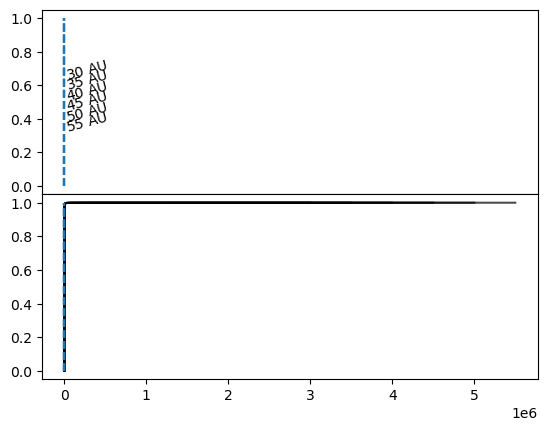

In [124]:
plot_aei(tno_class='all')

## Using Orbital Elements to construct and visualize orbits 

We can use the orbital elements from the TNOs to visualize their orbits (including comets). We can identify patterns in orbits of different dynamical classes, for example, the clustering of extreme objects that some researchers argue is evidence in favor of the existence of P9/PX. 

## Define functions first 

In [22]:
SunGM 		=	 4.*np.pi*np.pi/1.000037773533  #solar gravitation
MercuryGM 	= 	6.55371264e-06
VenusGM 	=   9.66331433e-05
EarthMoonGM =	1.20026937e-04
MarsGM 		=   1.27397978e-05;
JupiterGM   =	3.76844407e-02 + 7.80e-6
SaturnGM 	=  1.12830982e-02 + 2.79e-6
UranusGM 	=  1.72348553e-03 + 0.18e-6
NeptuneGM 	= 2.03318556e-03 + 0.43e-6

mu = SunGM + MercuryGM + VenusGM + EarthMoonGM + MarsGM + JupiterGM + SaturnGM + UranusGM + NeptuneGM


def q_func(E, a, e):
        '''
        Computes

        :math:`\\mathbf{q} = \(a(\\cos(E) - e), a\\sqrt{1-e^2}\\sin(E),0 \)`,

        the coordinate vector on the plane of the ellipse
        '''     
        q1 = a*(np.cos(E)-e)
        q2 = a*np.sqrt(1.-e**2)*np.sin(E)

        if type(q1) == float:
                return np.array([q1,q2,0.])
        else:
                return np.array([q1,q2,np.zeros_like(q1)])

def dqdt(E, a, e):
        '''
        Computes

        :math:`\\frac{\\mathrm{d}\\mathbf{q}}{\\mathrm{d} t} = \(- \\frac{n a \\sin E}{1 - e \\cos E}, \\frac{n a \\sqrt{1-e^2} \\cos E}{1 - e \\cos E},0 \)`,

        the velocity on the plane of the ellipse, where :math:`n = \\sqrt{G (M + m)}a^{-3\2} \\aprox \\sqrt{GM}a^{-3/2} = 2 \\pi a^{-3/2}` in our units.
        '''     
        n = np.sqrt(mu)/np.power(a,3./2)
        den = 1. - e*np.cos(E)
        q1 = n*a*np.sin(E)/den
        q2 = a*np.sqrt(1.-e**2)*np.cos(E)/den
        if type(q1) == float:
                return np.array([q1,q2,0])
        else:
                return np.array([q1,q2,np.zeros_like(q1)])


def R(omega, Omega, i):
	'''
	Computes the rotation matrix :math:`R = R(\\Omega, \\omega, i)` that maps from the plane of the ellipse to 3D space aligned with the ecliptic plane
	'''

	cO = np.cos(np.pi*Omega/180)
	sO = np.sin(np.pi*Omega/180)
	co = np.cos(np.pi*omega/180)
	so = np.sin(np.pi*omega/180)
	ci = np.cos(np.pi*i/180)
	si = np.sin(np.pi*i/180)

	R = np.array([[cO * co - sO * so * ci, - cO * so - sO * co * ci, sO * si],
				[sO * co + cO * so * ci, -sO * so + cO * co * ci, -cO * si],
				[si * so, si*co, ci]])


	return R

def eccentric_anomaly(t, a, e, t0, M0):
        '''
        Eccentric anomaly
        '''
        n = np.sqrt(mu)/np.power(a,3./2)
        f = lambda E : M0 + n*(t - t0) - E + e*np.sin(E)

        return root(f, n*(t - t0)).x


def ellipse_coordinates(a, e, i, Omega, omega, T_p, t0):
        period = np.sqrt(a**3)
        
        M0 = (T_p - t0)*(np.sqrt(mu)/np.power(a,3./2))

        time_steps = np.linspace(-period/2, period/2, 1000) + t0

        E = eccentric_anomaly(time_steps, a, e, t0, M0)

        q_vec = q_func(E, a, e)


        Rot = R(omega, Omega, i)

        x = Rot.dot(q_vec)

        return np.array(x[0])[0], np.array(x[1])[0], np.array(x[2])[0]


def full_ellipse(a, e, i, Omega, omega):
        E = np.linspace(0, 2*np.pi, 2000)
        
        q_vec = q_func(E, a, e)
        Rot = R(omega, Omega, i)


        x = np.einsum('ij,j...', Rot, q_vec)

        return x

def peri_loc(a, e, i, Omega, omega):
        E = 0.
        
        q_vec = q(E, a, e)
        Rot = R(omega, Omega, i)


        x = np.einsum('ij,j...', Rot, q_vec)

        return x


In [25]:
x = []
# node = Omega; peri = omega
for i in tnos:
    x.append(full_ellipse(i['a'], i['e'], i['incl'], i['node'], i['peri']))
tnos['vec'] = x

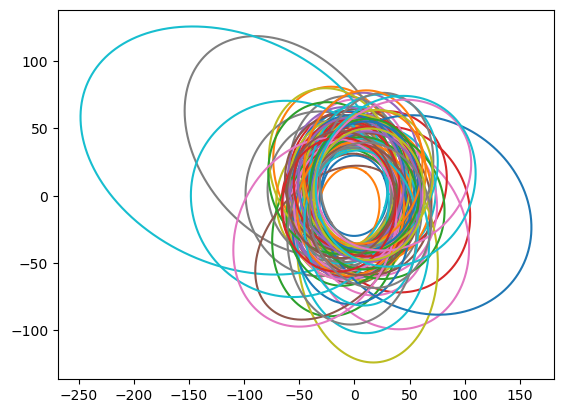

In [28]:
for i in tnos[:100]:
    plt.plot(i['vec'][:,0], i['vec'][:,1])

In [26]:
len(tnos), len(tnos[(tnos['a'] > 150) & (tnos['q'] > 30)])

(58916, 35)

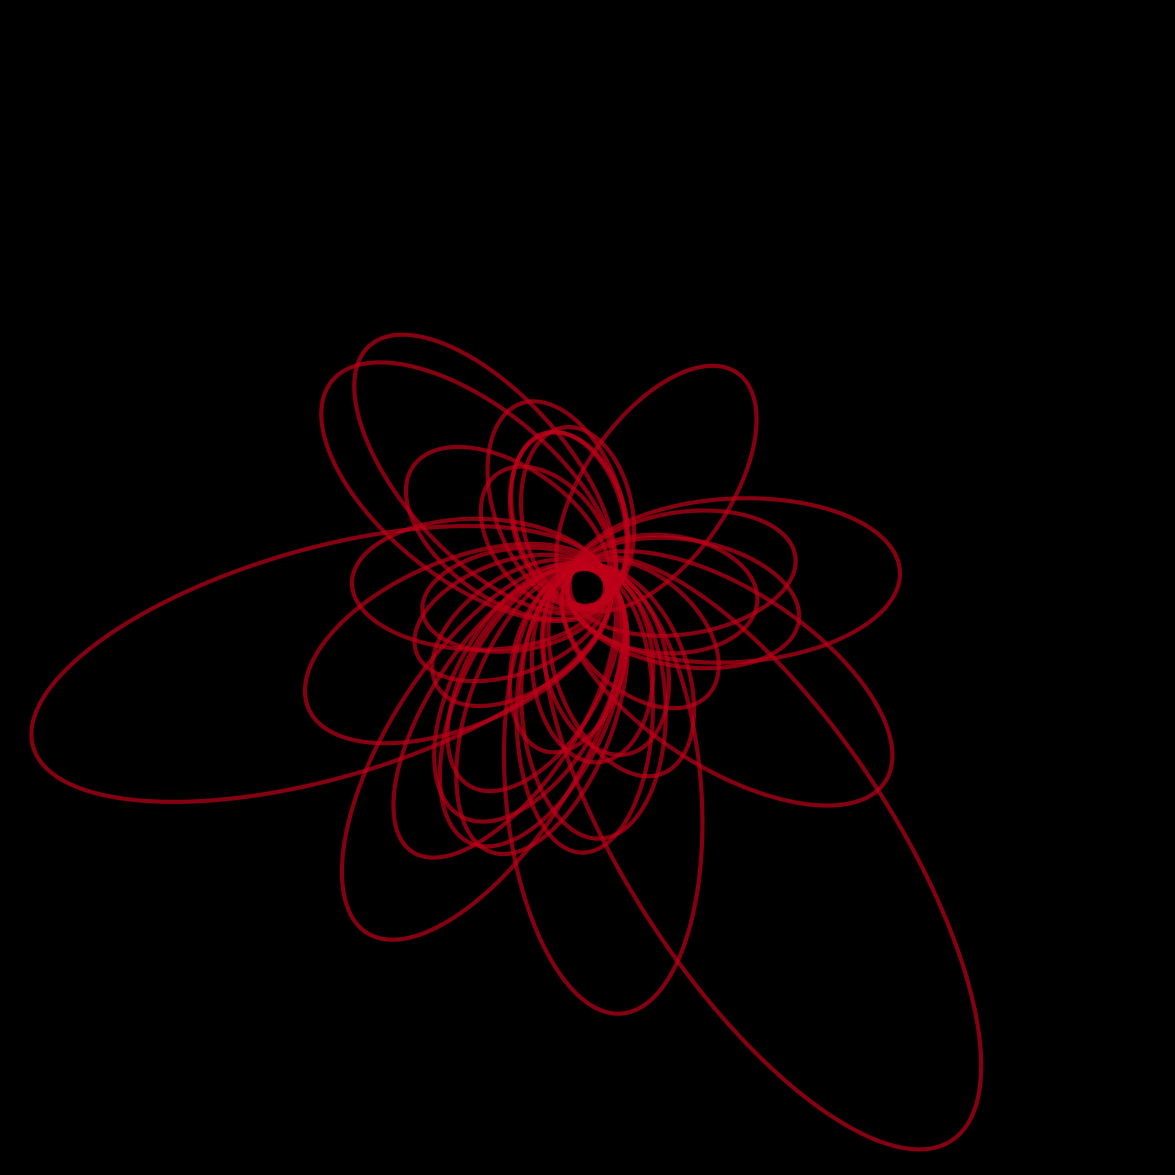

In [27]:
fig = plt.figure()
fig.set_size_inches(15,15)
plt.rcParams['figure.facecolor'] = 'black'

plt.axes().set_aspect('equal')


colors = {'Resonant' : '#9ed4bf', 'Classical' : '#9ed4bf', 'Scattering': '#9ed4bf',
          'Detached' : '#9ed4bf', 'Oort cloud' : '#9ed4bf', 'Inner Centaur' : '#9ed4bf'}
alphas = {'Resonant' : 0.1, 'Classical' : 0.1, 'Scattering' : 0.1, 'Detached': 0.1, 'Inner Centaur' : 0.1, 'Oort cloud' : 0.1}
alphas_dist = {'Resonant' : 0.2, 'Classical' : 0.2, 'Scattering' : 0.2, 'Detached': 0.2, 'Inner Centaur' : 0.2, 'Oort cloud' :0.2}



tnos.sort('a')
#for i in reversed(tnos):
    
#    if i['a'] < 100:
#        pl.plot(i['vec'][:,0], i['vec'][:,1], colors[i['class']], alpha=alphas[i['class']], linewidth=3)
#    else:
#        pl.plot(i['vec'][:,0], i['vec'][:,1], colors[i['class']], alpha=alphas_dist[i['class']], linewidth=3)
#pl.plot(xx[:,0], xx[:,1],  'xkcd:scarlet', alpha=1)

for i in tnos[(tnos['a'] > 150) & (tnos['q'] > 30)]:
    plt.plot(i['vec'][:,0], i['vec'][:,1], 'xkcd:scarlet', linewidth=3, alpha=0.7)
plt.xlim(-1000,1000)
plt.ylim(-1000,1000)


plt.axis('off')


#pl.savefig('all_p9.png', dpi = 300)
plt.show()

In [ ]:
# From Pedro: "This is expected, and it also says a lot about expected results from LSST!
#The S3M model predates the whole Planet 9 stuff (and is old enough that these more exotic populations are not representative of what we have learned from the more recent surveys)
#But this does an excellent job of showing that LSST will see the signal or not easily!"

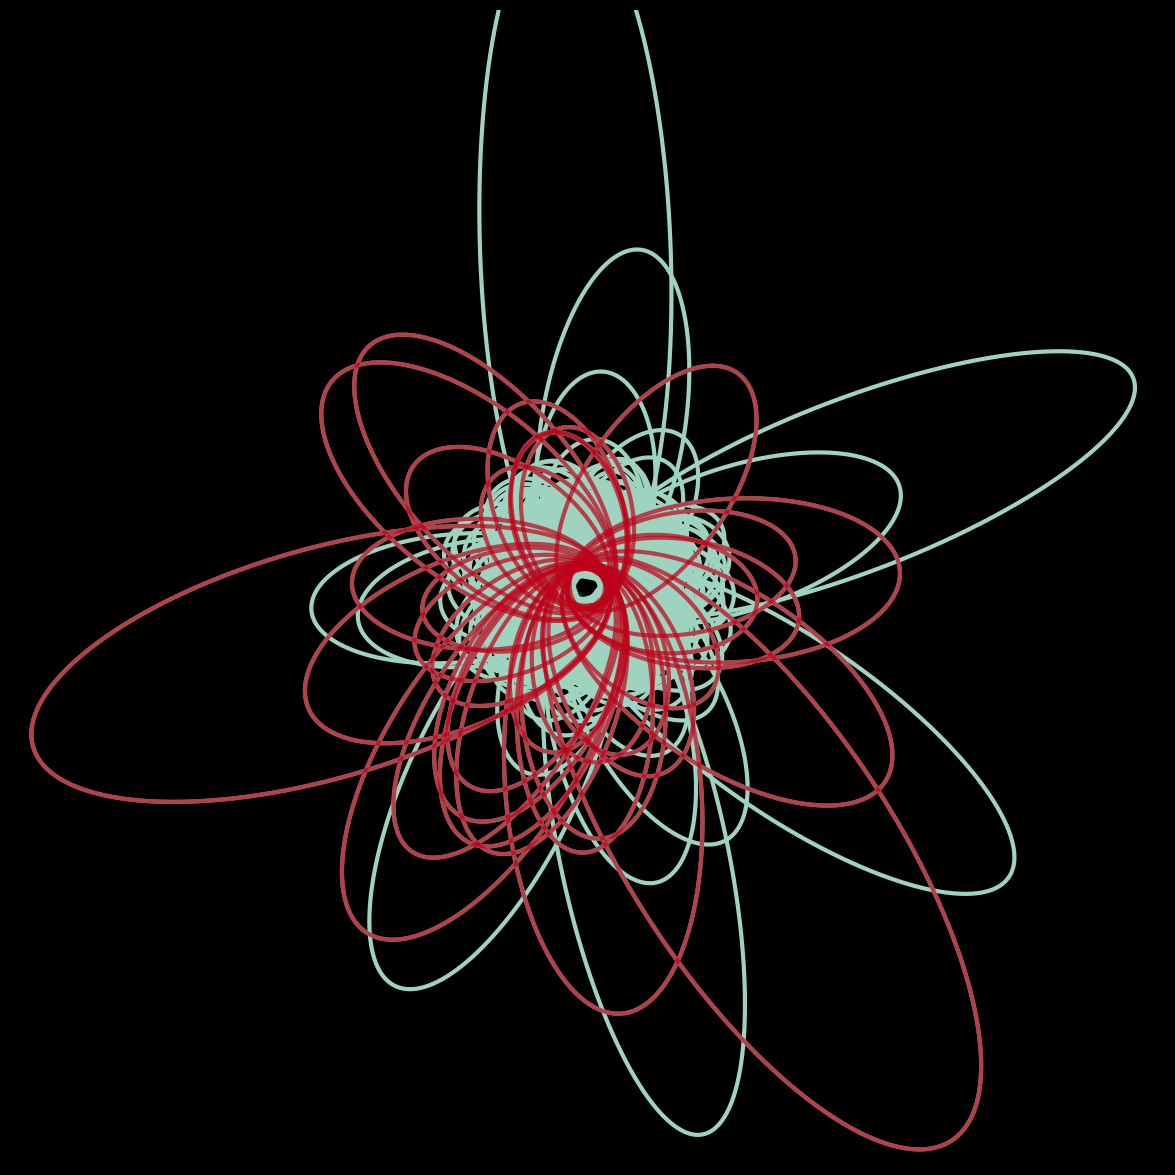

In [28]:
fig = plt.figure()
fig.set_size_inches(15,15)
plt.rcParams['figure.facecolor'] = 'black'

plt.axes().set_aspect('equal')


colors = {'Resonant' : '#9ed4bf', 'Classical' : '#9ed4bf', 'Scattering': '#9ed4bf',
          'Detached' : '#9ed4bf', 'Oort cloud' : '#9ed4bf', 'Inner Centaur' : '#9ed4bf'}
alphas = {'Resonant' : 0.1, 'Classical' : 0.1, 'Scattering' : 0.1, 'Detached': 0.1, 'Inner Centaur' : 0.1, 'Oort cloud' : 0.1}
alphas_dist = {'Resonant' : 0.2, 'Classical' : 0.2, 'Scattering' : 0.2, 'Detached': 0.2, 'Inner Centaur' : 0.2, 'Oort cloud' :0.2}



tnos.sort('a')
for i in reversed(tnos):
    
    if i['a'] < 100:
        #pl.plot(i['vec'][:,0], i['vec'][:,1], colors[i['class']], alpha=alphas[i['class']], linewidth=3)
        plt.plot(i['vec'][:,0], i['vec'][:,1], '#9ed4bf' , alpha=0.1, linewidth=3)
    else:
        #pl.plot(i['vec'][:,0], i['vec'][:,1], colors[i['class']], alpha=alphas_dist[i['class']], linewidth=3)
        plt.plot(i['vec'][:,0], i['vec'][:,1], '#9ed4bf', 0.2, linewidth=3)

for i in tnos[(tnos['a'] > 150) & (tnos['q'] > 30)]:
    plt.plot(i['vec'][:,0], i['vec'][:,1], 'xkcd:scarlet', linewidth=3, alpha=0.7)
plt.xlim(-1000,1000)
plt.ylim(-1000,1000)


plt.axis('off')


#pl.savefig('all_p9.png', dpi = 300)
plt.show()